In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:100]}

In [3]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

%set_env TF_GPU_ALLOCATOR=cuda_malloc_async

env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [1]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

label_features=['EW_Node_Location']


ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced,
                                      label_features=label_features,
                                      train_val_split=0.85, stride=1, padding=False,
                                      input_history_steps=40, input_future_steps=120, seed=69)

NameError: name 'datahandler' is not defined

In [ ]:
train_combined, val_combined = ds_gen.get_datasets(512, label_features=label_features, shuffle=True)
print(train_combined.element_spec)

(TensorSpec(shape=(None, 80, 9), dtype=tf.float64, name=None), {'EW_Node_Location': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 80, 9)]           0         
                                                                 
 conv1d (Conv1D)             (None, 49, 20)            5780      
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 10)            6410      
                                                                 
 flatten_1 (Flatten)         (None, 180)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               23168     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 EW_Node_Location (Dense)    (None, 2)                 130 

/home/user/Code/splid-challenge/base/prediction_models.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


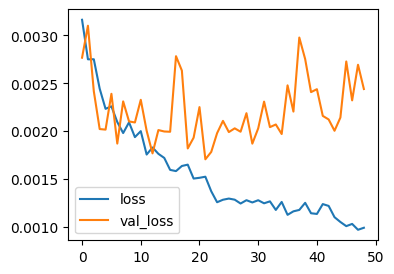

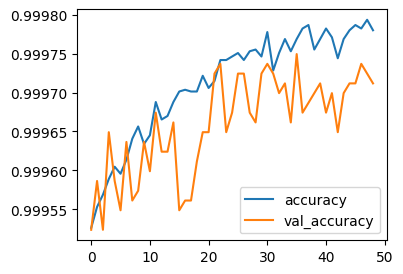

In [ ]:
dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,64],[32,32]], dense_layers=[64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[30000,0.8], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)

dense_model.summary()
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=50, verbose=1, plot_hist=False, callbacks=[])
dense_model.model.save_weights('tmp_model.hdf5')

dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [6]:
dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[20,32],[10,32]], dense_layers=[128,64], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[20000,0.8], seed=0)
dense_model._model.load_weights('tmp_model.hdf5')

In [ ]:
def localization_eval(ds_gen, gt_path, model, train=True, add_initial_node=False):

    t_ds, v_ds = ds_gen.get_datasets(512, label_features=label_features, shuffle=False, keep_identifier=True)
    ds = t_ds if train else v_ds

    ground_truth_labels = pd.concat([split_dataframes[k] for k in ds_gen.train_keys + ds_gen.val_keys])[['ObjectID', 'TimeIndex', 'EW_Node', 'EW_Type']].rename(columns={'EW_Node' : 'Node', 'EW_Type' : 'Type'})
    ground_truth_labels['Direction'] = 'EW' # For now just EW, see line above
    ground_truth_labels = ground_truth_labels[(ground_truth_labels['Direction'] == 'EW')]

    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    labels = np.concatenate([element['EW_Node_Location'] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])

    # get predictions
    preds = model.predict(inputs)
    preds_argmax = np.argmax(preds, axis=1)

    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)
    df['Location'] = labels
    df[f'Location_Pred'] = preds_argmax

    # add initial node prediction
    if add_initial_node:
        for obj in ds_gen.train_keys if train else ds_gen.val_keys:
            df = df.sort_index()
            df.loc[-1] = [int(obj), 0, 1, 1] # objid, timeindex, location, location_pred
            df.index = df.index + 1
            df = df.sort_index()
    
    df_filtered = df.loc[(df['Location_Pred'] == 1)]
    df_filtered = df_filtered.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)    

    # now, assign the real label to the locations
    mergeDf = df_filtered.merge(ground_truth_labels, how='left', on = ['ObjectID', 'TimeIndex'])

    ground_truth_from_file = pd.read_csv(gt_path).sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
    ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin(map(int, ds_gen.train_keys if train else ds_gen.val_keys))].copy()
    ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == 'EW')]

    evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
    precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F2: {f2:.2f}')
    print(f'RMSE: {rmse:.4}')
    print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

    return df.loc[(df['Location'] == 1) | (df['Location_Pred'] == 1)].merge(ground_truth_labels, how='left', on = ['ObjectID', 'TimeIndex'])

In [ ]:
eval_df = localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=False, add_initial_node=True)
# print(eval_df.head(50))

2494/2494 [==============================] - 2s 741us/step
Precision: 0.85
Recall: 0.84
F2: 0.84
RMSE: 0.2294
TP: 57 FP: 10 FN: 11


In [ ]:
eval_df = localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True, add_initial_node=True)

13916/13916 [==============================] - 10s 727us/step
Precision: 0.97
Recall: 0.80
F2: 0.83
RMSE: 0.0
TP: 327 FP: 10 FN: 84


In [12]:
false_preds = eval_df.loc[(eval_df['Location'] != eval_df['Location_Pred'])]
print(false_preds.head(80))
false_preds = eval_df[eval_df['Location'] != eval_df['Location_Pred']]
print(len(false_preds))
print(len(eval_df))

     ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
214       190       1609         1              0   ID   NK        EW
218       147       1561         1              0   ID   NK        EW
224       199       1381         1              0   ID   NK        EW
225       196        889         1              0   ID   NK        EW
226       160       2101         1              0   ID   NK        EW
..        ...        ...       ...            ...  ...  ...       ...
402       163        505         1              0   ID   NK        EW
403       164        781         1              0   ID   NK        EW
404       197       1165         1              0   ID   NK        EW
413       120       2016         1              0   IK   HK        EW
414       174        781         1              0   ID   NK        EW

[80 rows x 7 columns]
84
421
